<a href="https://colab.research.google.com/github/maximilianigl/DVRL/blob/master/POMDP_practical_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting ready #

The goal of this exercise is to understand *Value Iteration* in POMDPs.
As there's quite a lot going on, we'll slowly walk through every logical step involved, hopefully developing some intuitive understanding of why POMDPs are difficult and how they can be solved.

You should already understand the idea of *Value Iteration* in the fully observable case, i.e. in MDPs. Furthermore, we'll need *Bayes Rule* 

$$ P(A|B) = \frac{P(B|A) P(A)}{P(B)},$$

so make sure you know what's going on there.

# Chapter 0: The illustrative example #

In this exercise, we will be using the following example POMDP, taken from [here](http://ais.informatik.uni-freiburg.de/teaching/ws11/robotics2/pdfs/rob2-XX-POMDPs.pdf)

![Graphical Model of example POMDP](https://github.com/maximilianigl/pomdp-practical/blob/master/images/Graph_model.png?raw=true)

So, for rewards $r$, states $x_i$, actions $u_i$ and observations $z_i$ we have for the rewards in state $x_1$: 
$r(x_1, u_1) = -100$, $r(x_1, u_2) = 100$, $r(x_1, u_3) = -1$. 

The transition dynamics into state $x_1$ are given by: $p(x_1'|x_1, u_3) = 0.2$ and $p(x_1'|x_2, u_3)= 0.8$, i.e. there's only a chance to switch the state if we pick action $u_3$. Importantly, $u_3$ is the *sensing* action, i.e. we only get observations when we pick $u_3$. 

The observation probabilities in $x_1$ are given by $p(z_1|x_1) = 0.7$, $p(z_2|x_1) = 0.3$.
Lastly, once we pick $u_1$ or $u_2$, we either get a big positive or negative reward *and the episode ends*.

Below I already implemented the corresponding functions to represent that POMDP:

In [0]:
rewards = [
    [-100, 100, -1],
    [100,  -50, -1]
]
def reward(state, action):
  """
  Returns the reward for an `action` in a certain `state`. 
  
  Args: 
    state (int): The state for which to return the reward
    action (int): The action taken in state.

  Returns:
    int: The reward
  """
  
  return rewards[state-1][action-1]

transitions = [
    [0.2, 0.8],
    [0.8, 0.2]
]

def transition_probs(state, action, new_state):
  """
  Returns the probability to transition to `new_state` when taking action `action` in state `state`.
  
  Args:
    state (int): The current state
    action (int): Action taken in `state`
    new_state (int): The new state in which to transition to
    
  Returns:
    float: Probability to transition into new_state
  """
  if action != 3:
    return state == new_state
  else:
    return transitions[state-1][new_state-1]
  
observations = [
    [0.7, 0.3],
    [0.3, 0.7]
]
def observation_probs(state, action, obs):
  """
  Returns the probability of observing `obs` in state `state` when taking `action`.
  When not taking u_3 as action, set p(z_1|x_i) = 1 for both states, i.e. we don't learn anything from the observation.
  
  Args:
    state (int): The current state
    action (int): Action taken in `state`
    obs (int): The observation whose probability we evaluate
    
  Returns:
    float: Probability of observation
  """
  if action != 3:
    # Set p(z_1|x_i)=1 in both states if we're not using u_3
    return obs == 1
  else:
    return observations[state-1][obs-1]


# Chapter 1: Planning in the belief MDP #

As you should have learned in the lecture this morning, we can see the POMDP as a *Believe MDP*, e.g. as explained [here](https://en.wikipedia.org/wiki/Partially_observable_Markov_decision_process#Belief_MDP):

*A Markovian belief state allows a POMDP to be formulated as a Markov decision process where every belief is a state. The resulting belief MDP will thus be defined on a continuous state space (even if the "originating" POMDP has a finite number of states: there are infinite belief states (in $B$) because there are an infinite number of mixtures of the originating states (of $S$), since there are infinite beliefs for any given POMDP.*

Before reasoning about how to solve the POMDP by using Value Iteration to find the best action for *every* possible belief state, let's first try to find the best action to take for *one* starting belief state.

## 1.1 The 1-step horizon ##

First, let's assume we can only take *one* action and then the episode ends. 

### The expected reward ###

Given a belief $b=[p_1, 1-p_1]$ of being in state 1 or 2 respectively, what is the expected reward for taking action $u_1$ or $u_2$?

**Question:**  Fill out the function below.

**Note:** For the implementation, because we only have two states, we can represent the belief by $p_1$, i.e. the probability to be in state 1, with the remaining probability to be in state 2 being of course $1-p_1$.

In [0]:
def reward_b(p1, action):
  """
  Compute the expected reward for taking a certain `action`.
  
  Args:
    p1 (float): Belief to be in state 1
    action (int): Action taken
    
  Returns:
    float: Expected reward.
  
  """
  
  
  return p1 * reward(state=1, action=action) + (1-p1) * reward(state=2, action=action)

Let's visualize this for the different actions (just run the code below). 



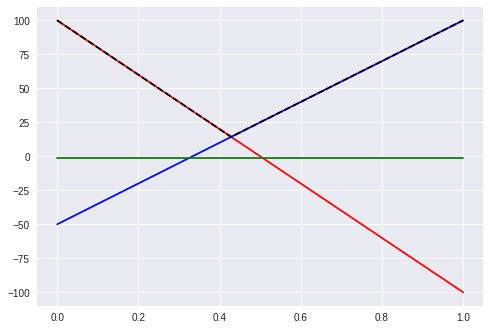

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# With numpy, operations like +/-/*// are performed element-wise, 
# so unless you did something weird above, we can evaluate the values of all 
# beliefes in parallel.
p1s = np.linspace(0,1)

plt.plot(p1s, reward_b(p1s, action=1), color='red')
plt.plot(p1s, reward_b(p1s, action=2), color='blue')
plt.plot(p1s, reward_b(p1s, action=3), color='green')

# We'll need this one later
# plt.plot(p1s, one_step_value(p1s), color='black', linestyle='--')
plt.show()



**Question:** Why does this make sense? What's the best action to take in each belief state (assuming we can only take this one action and the episode ends afterwards)? Is the resulting function of 'best possible expected reward we can achieve in each belief state' convex ;)? If yes - why does this make intuitive sense? Is it piecewise linear? 

Because we'll need this in the 2-step case below, let's write a function which returns us the best achievable 1-step return for each possible belief

**Question:**  Fill out the function below.

(**Hint:** The numpy function you're looking for is `np.maximum` and not `np.max`.)

In [0]:
def one_step_value(p1):
  """
  Compute the 1-step value for a given belief.
  
  Args:
    p1 (float): Belief to be in state 1
    
  Returns:
    float: Expected reward.
  
  """
  
  return np.maximum(reward_b(p1, action=1), reward_b(p1, action=2), reward_b(p1, action=3))
  

Go back up to the plot, uncomment the remaining line and plot this function as well, just to check it does what it's supposed to do.

## 1.2 Planning for with a 2 step horizon ## 

If we take $u_1$ or $u_2$, the episode ends immediately. However, when we take $u_3$ we actually get an observation (i.e. more information) and can take another action. So the value in the above plot for taking $u_3$ is not true if we look at an horizon of length $>1$. So let's look at next closest thing and fix the horizon length to 2. 


### Updating the belief ###

The first thing we need to do is figure out how to update our belief when we take an action and get an observation back from the environment.

**Question:** Please fill out the function below to compute the updated belief given the past belief, the action taken and the observation recieved from the environment. 

**Note:** We need to get the posterior $p(s'|a,o,b) = \sum_s p(s'|a,o,s) b(s)$, i.e. not only do we need to use Bayes rule to go from our model $p(o|s)$ to the posterior, but we also need to marginalise over our previous belief distribution. Try figuring out the formula by yourself (or in groups) and check with for example slide 16 [here](https://www.cs.cmu.edu/~ggordon/780-fall07/lectures/POMDP_lecture.pdf). 



In [0]:
# Helper function
def prior_next_state(p1, action, next_state):
  """
  Compute the probability p(next_state|action, p1), i.e. the prior probability
  (before taking any observation into account)
  to be in state `next_state` when taking `action`, given our current belief 
  as represented by p1
  
  Args:
    p1 (float): Belief to be in state 1
    action (int): Action taken
    next_staet (int): Next state
    
  Returns:
    float: Prior probability to be in state `next_state`
  
  """
  return (p1 * transition_probs(state=1, action=action, new_state=next_state) +
          (1-p1) * transition_probs(state=2, action=action, new_state=next_state))



def belief_update(p1, action, obs):
  """
  Compute the new probability `p1` to be in state 1.
  
  Args:
    p1 (float): Belief to be in state 1
    action (int): Action taken
    obs (int): Observation recieved from the environment
    
  Returns:
    float: Updated belief to be in state 1
  
  """
  
  p_o_marginal = (prior_next_state(p1, action, next_state=1) * observation_probs(state=1, action=action, obs=obs) +
                  prior_next_state(p1, action, next_state=2) * observation_probs(state=2, action=action, obs=obs))
  
  
  p1_new = observation_probs(state=1, action=action, obs=obs) * prior_next_state(p1, action, next_state=1) / p_o_marginal
  return p1_new
  

Ok, let's just visualize that again. Just execute the field below and think about whether the result makes sense.

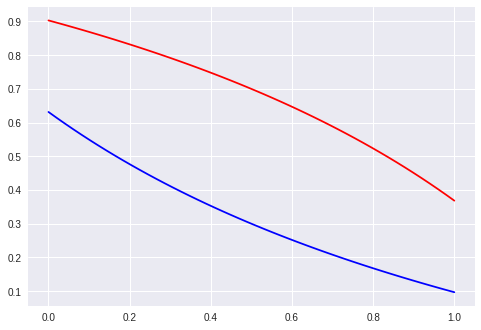

In [33]:
p1s = np.linspace(0,1)

# Let's plot the belief to be in state 1 for both possible observations that we
# Could get when taking action 3

plt.plot(p1s, belief_update(p1s, action=3, obs=1), color='red')
plt.plot(p1s, belief_update(p1s, action=3, obs=2), color='blue')
plt.plot()

### 2 step planning for actions $u_3$###

**Question:** Ok, now, let's write a function that computes the *expected* two step return for taking action $u_3$. To help, I've provided the `simulate` function, that returns the probability for observation 1 given a certain belief $p_1$.

In [0]:
def simulate(p1):
  """
  Returns the probability for observation 1 when our current belief is given
  by p1 and we exectue the sensing action u3
  
  Args:
    p1 (float): Belief to be in state 1
    
  Returns:
    float: probability to observe o1 when taking action 3
  """
  p1_prime = (p1 * transition_probs(state=1, action=3, new_state=1) +
             (1-p1) * transition_probs(state=2, action=3, new_state=1))
  
  p_o1 = (p1_prime * observation_probs(state=1, action=3, obs=1) + 
          (1-p1_prime) * observation_probs(state=2, action=3, obs=1))
          
  return p_o1
  
  

def value_taking_u3_first(p1):
  """
  Compute the 2-step value for a given belief when we take action u_3
  
  Args:
    p1 (float): Belief to be in state 1
    
  Returns:
    float: Expected reward.
  """
  p_o1 = simulate(p1)
          
  new_belief_o1 = belief_update(p1, action=3, obs=1)
  new_belief_o2 = belief_update(p1, action=3, obs=2)
          
  return (p_o1 * one_step_value(new_belief_o1) + 
          (1-p_o1) * one_step_value(new_belief_o2))




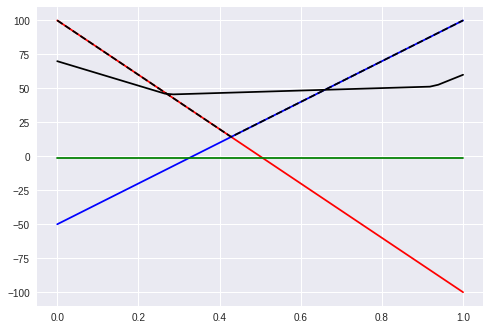

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# With numpy, operations like +/-/*// are performed element-wise, 
# so unless you did something weird above, we can evaluate the values of all 
# beliefes in parallel.
p1s = np.linspace(0,1)

plt.plot(p1s, reward_b(p1s, action=1), color='red')
plt.plot(p1s, reward_b(p1s, action=2), color='blue')
plt.plot(p1s, reward_b(p1s, action=3), color='green')

# We'll need this one later
plt.plot(p1s, one_step_value(p1s), color='black', linestyle='--')

plt.plot(p1s, value_taking_u3_first(p1s), color='black')
plt.show()

**Question:** Again, does that make intuitive sense? Why? And is the resulting value function of 'best choices' piecewise linear and convex :)? 

# Chapter 2: From planning to Value Iteration #

Now, those nice plots we have made so far are what we would like to get out of Value Iteration: Telling us exactly what the expected value for each action is: Each line corresponds to one action we can take now. This allows us to, for each possible belief, pick the action with the highest expected return. 

So far, we've created those plots by just picking a bunch of points (50 to be exact) and evaluate the value for all possible actions at all of those points. Of course, that scales terribly. For one, planning more and more into the future becomes costly. But more importantly, our simple POMDP has only two states. If it had more, the resulting belief distribution would become higher dimensional, requiring more and more points to cover it with sufficient accuracy. So what can we do?

Well, we can realise that the resulting value function for any horizon length will always be convex (why?) and consist of a *finite* number of linear (why linear?) segments, in other words it is *piecewise linear and convex* (PWLC).

## 2.1 From Point to Lines ##

Let's recap what we did above: How did we move from the 1-step case to 2 steps?

1. For each belief $b$, we computed the new belief $b'$ *for each possible observation $z_i$ that we could receive* 
2. We evaluated the new belief $b'$ using our old `one_step_value` function
2. We summed all those values up, weighted by how likely each observation was (as given by the `simulate` function). 

Now, we know that the value function is represented by a finite number of *lines*. Can we apply the same 3 steps to lines instead of points? Why? 

This is shown wonderfully in the [POMDP tutorial](http://pomdp.org/tutorial/pomdp-vi-example.html):

We start with the Horizon 1 value function:

![Horizon 1 value function](https://github.com/maximilianigl/pomdp-practical/blob/master/images/Tutorial_1.png?raw=true)

Note that here the colors on the bottom represent which action is optimal.

Next, for each action and for each possible observation, we transform this one step value function based on how likely this observation is and how this would affect our belief state. In this example, there are 3 possible observations, so we get three transformed value functions (for action $a_1$):

![Transformed horizon 1  value function](https://github.com/maximilianigl/pomdp-practical/blob/master/images/Tutorial_2.png?raw=true)

Now we need to sum those up. But how? Add all blue lines together? That would mean always taking $a_1$, independenlty of the observation. So instead, we can come up with different strategies like $(z_1:a_2, z_2:a_1, z_3:a_1)$, i.e. take $a_2$ when we see $z_1$, take $a_1$ for $z_2$ and so on. Here that would mean add the left green line, the middle blue line and the right blue line. But which strategy is best? Above, when we did it for a fixed initial belief, we just took the `max` operation given the new belief. However, now we need to think about *all* possible initial believes, so the optimal strategy depends on our *original* belief $b$ which is still shown on the $x$-axis. We can easily read off the best strategies like so: 

![Best response strategy](https://github.com/maximilianigl/pomdp-practical/blob/master/images/Tutorial_3.png?raw=true)

where we see that there are 4 best strategies reacting to observations, depending on what is our starting belief. 
Each of those strategies tells us which lines to add up, given the resulting value function for taking action $a_1$:

![Value function for a1](https://github.com/maximilianigl/pomdp-practical/blob/master/images/Tutorial_4.png?raw=true).

Now we can do the same thing again with $a_2$ and take the max between the two and voila, we have the horizon 2 value function.  










## 2.2 Playing around with Lines ##

But grey is all theory, so let's just play around with Value Iteration. Because we're lazy and don't want to implement it from scratch, let's use [this](https://github.com/pemami4911/POMDPy) repo with 98 stars that implements Value Iteration for the Tiger problem, which is very similar to our setting: A tiger is behind one of two doors and you can either open one of the doors, or listen for a *roar*, giving you a noisy observation.

In [1]:
# Install a POMDP Value Iteration solver because 
# implementing that in half an afternoon is a bit ambitious

!pip install git+https://github.com/pemami4911/POMDPy.git

  Cloning https://github.com/pemami4911/POMDPy.git to /tmp/pip-req-build-z725dlef
  Stored in directory: /tmp/pip-ephem-wheel-cache-0add2j7f/wheels/b0/95/04/cadab923d0dcd09126efc00b0a9d8cfc7cabe27aa22fef4340
Successfully built POMDPy


### Running Value Iteration ###

In the field below, set the planning horizon and run it. I'd recommend starting with one and working your way up ;). The next field allows you to plot the resulting value function.

In [67]:
from pomdpy import Agent
from pomdpy.solvers import ValueIteration
from pomdpy.log import init_logger
from examples.tiger import TigerModel

planning_horizon = 1

args = {
    'planning_horizon': planning_horizon,
    'n_epochs': 1,
    'max_steps': 1,
    'env': 'Tiger',
    'solver': 'ValueIteration',
    'discount': 1,
    'save': True,
}

env = TigerModel(args)
env.weight_dir = ('./')
agent = Agent(env, ValueIteration)
test = agent.discounted_return()

{'discount': 1,
 'env': 'Tiger',
 'max_steps': 1,
 'n_epochs': 1,
 'planning_horizon': 2,
 'save': True,
 'solver': 'ValueIteration'}
	Epoch #1 RESULTS
agent - discounted return statistics
Name =  discounted return
Running Total =  -1.0
Mean =  -1.0
Count =  1.0
Variance =  0.0
Max =  -1.0
Min =  -1.0
agent - undiscounted return statistics
Name =  undiscounted return
Running Total =  -1.0
Mean =  -1.0
Count =  1.0
Variance =  0.0
Max =  -1.0
Min =  -1.0
agent - Time
Name =  Time
Running Total =  0.19347071647644043
Mean =  0.19347071647644043
Count =  1.0
Variance =  0.0
Max =  0.19347071647644043
Min =  0.19347071647644043
  [*] save ./VI_planning_horizon_2.pkl
   [-] save_pkl : 0.00057 sec


agent - epochs: 1
agent - ave undiscounted return/step: -1.0 +- 0.0
agent - ave discounted return/step: -1.0 +- 0.0
agent - ave time/epoch: 0.19347071647644043


There are 6 alpha-vectors
{'action': 0, 'v': array([-1., -1.])}
{'action': 0, 'v': array([ 7.5, -4. ])}
{'action': 0, 'v': array([-4. ,  7.5])}
{'action': 2, 'v': array([ 10., -20.])}
{'action': 2, 'v': array([  9.5, -20.5])}
{'action': 1, 'v': array([-20.,  10.])}


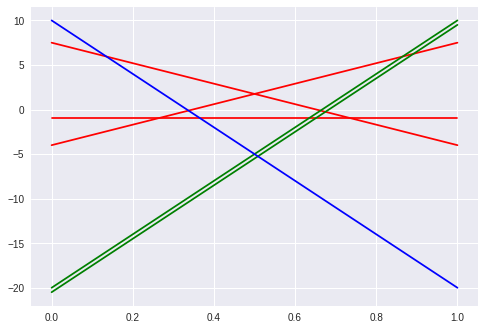

In [68]:
import numpy as np
import matplotlib.pyplot as plt
ps = np.linspace(0,1)

line = lambda p, v0, v1: p * v0 + (1-p) * v1

colors = ['red', 'blue', 'green']

import pickle
alpha_vectors = pickle.load(open('VI_planning_horizon_{}.pkl'.format(planning_horizon), 'rb'))


print("There are {} alpha-vectors".format(len(alpha_vectors)))
for av in alpha_vectors:
  print(vars(av))
  plt.plot(ps, line(ps, av.v[0], av.v[1]), color = colors[av.action])

  


**Question:** Have you tried the above for several different `planning_horizon`s? Does the result look reasonable? Why not?

Looks like there's a bug....

**Bonus question:** Fix the bug. Below I copy-pasted his code for his value iteration solver for your convenience. Because the solver is passed into his `Agent` as argument, we can just replace it with our version. Tipp: Look for line 56, marked by `# TODO: Fix BUG`, that's where the magic happens.

In [0]:
from pomdpy.solvers.solver import Solver
from pomdpy.solvers.alpha_vector import AlphaVector
from scipy.optimize import linprog
import numpy as np
from itertools import product


class ValueIteration(Solver):
    def __init__(self, agent):
        """
        Initialize the POMDP exact value iteration solver
        :param agent:
        :return:
        """
        super(ValueIteration, self).__init__(agent)
        self.gamma = set()
        self.history = agent.histories.create_sequence()

    @staticmethod
    def reset(agent):
        return ValueIteration(agent)

    def value_iteration(self, t, o, r, horizon):
        """
        Solve the POMDP by computing all alpha vectors
        :param t: transition probability matrix
        :param o: observation probability matrix
        :param r: immediate rewards matrix
        :param horizon: integer valued scalar represented the number of planning steps
        :return:
        """
        discount = self.model.discount
        actions = len(self.model.get_all_actions())  # |A| actions
        states = self.model.num_states  # |S| states
        observations = len(self.model.get_all_observations())  # |Z| observations
        first = True

        # initialize gamma with a 0 alpha-vector
        dummy = AlphaVector(a=-1, v=np.zeros(states))
        self.gamma.add(dummy)

        # start with 1 step planning horizon, up to horizon-length planning horizon
        for k in range(horizon):
            # new set of alpha vectors to add to set gamma
            gamma_k = set()
            # Compute the new coefficients for the new alpha-vectors
            v_new = np.zeros(shape=(len(self.gamma), actions, observations, states))
            idx = 0
            for v in self.gamma:
                for u in range(actions):
                    for z in range(observations):
                        for j in range(states):
                            for i in range(states):
                                
                                # TODO: Fix BUG
                                # v_i_k * p(z | x_i, u) * p(x_i | u, x_j)
#                                 v_new[idx][u][z][i] += v.v[i] * o[u][i][z] * t[u][j][i]
                                v_new[idx][u][z][j] += v.v[i] * o[u][i][z] * t[u][i][j]

                idx += 1
            # add (|A| * |V|^|Z|) alpha-vectors to gamma, |V| is |gamma_k|
            for u in range(actions):
                c = self.compute_indices(idx, observations)
                for indices in c:  # n elements in c is |V|^|Z|
                    for z in range(observations):
                        temp = np.zeros(states)
                        for i in range(states):
                            temp[i] = discount * (r[u][i] + v_new[indices[z]][u][z][i])
                        gamma_k.add(AlphaVector(a=u, v=temp))
            self.gamma.update(gamma_k)
            if first:
                # remove the dummy alpha vector
                self.gamma.remove(dummy)
                first = False
            self.prune(states)
            #  plot_gamma(title='V(b) for horizon T = ' + str(k + 1), self.gamma)

    @staticmethod
    def compute_indices(k, m):
        """
        Compute all orderings of m elements with values between [0, k-1]
        :param k: Number of alpha-vectors
        :param m: Number of observations
        :return: list of lists, where each list contains m elements, and each element is in [0, k-1].
        Total should be k^m elements
        """
        x = list(range(k))
        return [p for p in product(x, repeat=m)]

    def prune(self, n_states):
        """
        Remove dominated alpha-vectors using Lark's filtering algorithm
        :param n_states
        :return:
        """
        # parameters for linear program
        delta = 0.0000000001
        # equality constraints on the belief states
        A_eq = np.array([np.append(np.ones(n_states), [0.])])
        b_eq = np.array([1.])

        # dirty set
        F = self.gamma.copy()
        # clean set
        Q = set()

        for i in range(n_states):
            max_i = -np.inf
            best = None
            for av in F:
                if av.v[i] > max_i:
                    max_i = av.v[i]
                    best = av
            Q.update({best})
            F.remove(best)
        while F:
            av_i = F.pop()  # get a reference to av_i
            F.add(av_i)  # don't want to remove it yet from F
            dominated = False
            for av_j in Q:
                c = np.append(np.zeros(n_states), [1.])
                A_ub = np.array([np.append(-(av_i.v - av_j.v), [-1.])])
                b_ub = np.array([-delta])

                res = linprog(c, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=b_ub, bounds=(0, None))
                if res.x[n_states] > 0.0:
                    # this one is dominated
                    dominated = True
                    F.remove(av_i)
                    break

            if not dominated:
                max_k = -np.inf
                best = None
                for av_k in F:
                    b = res.x[0:2]
                    v = np.dot(av_k.v, b)
                    if v > max_k:
                        max_k = v
                        best = av_k
                F.remove(best)
                if not self.check_duplicate(Q, best):
                    Q.update({best})
        self.gamma = Q

    @staticmethod
    def check_duplicate(a, av):
        """
        Check whether alpha vector av is already in set a

        :param a:
        :param av:
        :return:
        """
        for av_i in a:
            if np.allclose(av_i.v, av.v):
                return True
            if av_i.v[0] == av.v[0] and av_i.v[1] > av.v[1]:
                return True
            if av_i.v[1] == av.v[1] and av_i.v[0] > av.v[0]:
                return True

    @staticmethod
    def select_action(belief, vector_set):
        """
        Compute optimal action given a belief distribution
        :param belief: dim(belief) == dim(AlphaVector)
        :param vector_set
        :return:
        """
        max_v = -np.inf
        best = None
        for av in vector_set:
            v = np.dot(av.v, belief)

            if v > max_v:
                max_v = v
                best = av

        if best is None:
            raise ValueError('Vector set should not be empty')

        return best.action, best


# Epilogue

This is the first version of this tutorial. I assume that whoever will hold the POMDP tutorial next year is likely to re-use the material here. So both for my own curiosity as well as the benefit of all future CDT generations, it would be great if you could provide some feedback in this *very short* [feedback form](https://docs.google.com/forms/d/e/1FAIpQLSdOFYkBDFt2biLdZj6fyvnrjUDhRzDjSD6CYg9CE7A1Ohnq_A/viewform?usp=sf_link):)